In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

2023-05-03 16:52:24.453885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [85]:
vueltas = pd.read_csv("../dataset_todos_pilotos/vueltas_austria_final.csv")

vueltas.drop(['Piloto'], axis = 1, inplace = True)

vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020, 2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2022]

#vueltas_test = vueltas_test[vueltas_test['Piloto'] == "alonso"]

vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)

#vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
#vueltas_test.drop(['Piloto'], axis = 1, inplace = True)


vueltas_train = vueltas_train.astype(float)
vueltas_test = vueltas_test.astype(float)

In [86]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)

In [87]:
trainX = []
trainY = []
testX = []
testY = []
loopback = 10 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 5])
    #print(vueltas_train_scaler[i + future - 1:i + future, 5])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
    testY.append(vueltas_test_scaler[i + future - 1:i + future,5])


In [88]:
trainX, trainY, testX, testY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

In [89]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="adam", loss= "mse") ##Cambiar esto para la siguiente reunion (positivo 1, negativo 0)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10, 256)           284672    
                                                                 
 dropout_11 (Dropout)        (None, 10, 256)           0         
                                                                 
 lstm_12 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 481,921
Trainable params: 481,921
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
67/67 [==============================] - 5s 39ms/step - loss: 0.0237
Epoch 2/12
67/67 [==============================] - 3s 39ms/step - loss: 0.0119
Epoch 3/12
67/67 [==============================] - 3s 40ms/step - loss: 0.0097
Epoch 4/12
67/67 [==============================] - 3s 46ms/step - loss: 0.0087
Epoch 5/12
67/67 [==============================] - 3s 39ms/step - loss: 0.0078
Epoch 6/12
67/67 [==============================] - 3s 39ms/step - loss: 0.0077
Epoch 7/12
67/67 [==============================] - 3s 39ms/step - loss: 0.0073
Epoch 8/12
67/67 [==============================] - 3s 39ms/step - loss: 0.0073
Epoch 9/12
67/67 [==============================] - 3s 44ms/step - loss: 0.0069
Epoch 10/12
67/67 [==============================] - 3s 40ms/step - loss: 0.0072
Epoch 11/12
67/67 [==============================] - 3s 40ms/step - loss: 0.0063
Epoch 12/12
67/67 [==============================] - 3s 43ms/step - loss: 0.0066


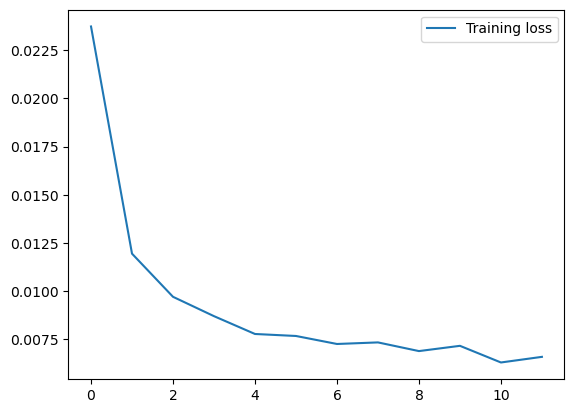

In [90]:
history = model.fit(trainX, trainY, epochs=12, batch_size=64, validation_split=0.0, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [91]:
clases = np.unique(trainY[:,0])
clases

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [92]:
f = lambda x: np.argwhere(x == clases)
f = np.vectorize(f)
y_real = f(testY[:,0])

In [93]:
predictions = model.predict(testX)

36/36 [==============================] - 1s 10ms/step


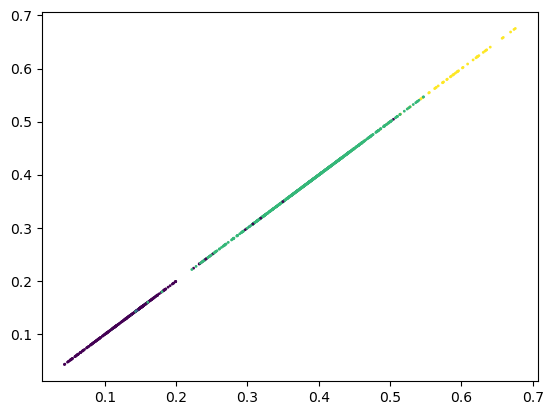

In [94]:
plt.scatter(predictions[:,0], predictions[:,0], s=1, c=y_real+1)

In [95]:
y_real_train = f(trainY[:,0])

In [96]:
predictions_train = model.predict(trainX)

133/133 [==============================] - 1s 10ms/step


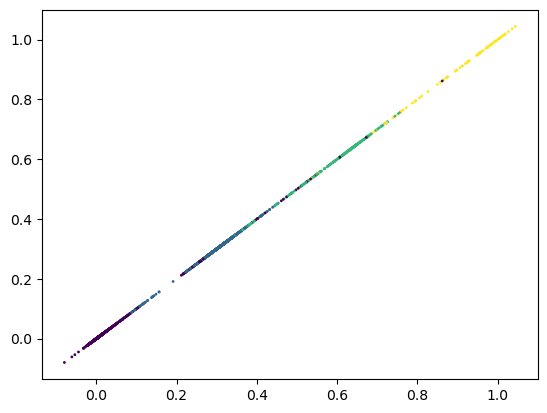

In [97]:
plt.scatter(predictions_train[:,0], predictions_train[:,0], s=1, c=y_real_train+1)

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictions, y_real, test_size=0.3, stratify=y_real)

In [81]:
rl = LogisticRegression(random_state=0, penalty=None).fit(X_train, y_train)

In [82]:
pred_test_2 = rl.predict(X_test)

In [83]:
print(confusion_matrix(y_test, pred_test_2))
print(classification_report(y_test, pred_test_2))

[[6 0 0]
 [0 7 0]
 [0 0 4]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         4

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [103]:
sum(vueltas_test['Stint'] == 2.0)

10